In [1]:
import requests
import json
import re
import os
import pandas as pd 
import numpy as np
import random
import pickle
from recipe_loading import *
from qty_mapping import *

In [2]:
from sentence_transformers import SentenceTransformer, CrossEncoder
from ranker import *
from preprocessor import *
from mapper import Mapper
from display_products import DisplayProducts
import joblib

The steps followed here are:

1) Load 1m recipe
2) Standardise the units
3) Load density info
4) Calculate the required amount of each ingredient

In [3]:
# import zipfile
# corpus_zip = zipfile.ZipFile('/Users/mvellera/USF/Intersession/Practicum (Target)/Data/recipe1M_layers/layer1.zip', 'r')
# recipe_str = corpus_zip.read(corpus_zip.namelist()[0])
# recipe = json.loads(recipe_str)

In [4]:
# filepath = "/Users/mvellera/USF/Intersession/Practicum (Target)/Data/recipe1M_layers/layer1.json"
# op_file_path = "data/ing_density.csv"
filepath = "../../../data/recipe1M_layers/layer1.json"
op_file_path = "../../data/ing_density.csv"

with open(filepath) as json_data:
    recipe = json.load(json_data)

In [5]:
# filepath = "/Users/mvellera/USF/Intersession/Practicum (Target)/Data/recipe1M_layers/layer2.json"
# filepath = "/Users/chahaksethi/Desktop/Target/data/1m_recipe/recipe1M_layers/layer2.json"
# with open(filepath) as json_data:
#     recipe_images = json.load(json_data)

In [6]:
# Set input file directory
ip_file_dir = "../../data/"

# Get grocery product hierarchy information
group10 = pd.read_csv(os.path.join(ip_file_dir, 
                                   'group10_header.csv'),
                      sep='\t', 
                      low_memory=False)

# Get scraped information for the above products
products = pd.read_csv(os.path.join(ip_file_dir,
                                    'scraped/products.csv'))

# Merge scraped information into the hierarchy table
group10 = pd.merge(group10, products, 
                   how = 'left', on = 'tcin')

# Preprocess the table
group10 = preprocess_df(group10)

In [7]:
bi_encoder_name = "multi-qa-MiniLM-L6-cos-v1"
cross_encoder_name = "cross-encoder/ms-marco-MiniLM-L-4-v2"
k=3

In [8]:
def get_embeddings(path):
#Load sentences & embeddings from disc
    with open(path, "rb") as fIn:
        stored_data = pickle.load(fIn)
        stored_embeddings = stored_data['embeddings']
    return stored_embeddings
    
def get_tcin_sentence_map(path):
#Load sentences & embeddings from disc
    with open(path, "rb") as fIn:
        stored_data = pickle.load(fIn)
        df = pd.DataFrame()
        df['tcin'] = stored_data['ids']
        df['sentence'] = stored_data['sentences']
    return df

bi_encoder = SentenceTransformer(bi_encoder_name)

# Get list of preprocessed product titles
product_titles = group10['title'].str.lower().values

l1_ranker = TransformerRanker(model=bi_encoder, product_ids=group10['tcin'], max_rank=3)
with open('../../data/embeddings/hier_embeddings3.pkl', "rb") as fIn:
    stored_data = pickle.load(fIn)
    stored_ids = stored_data['ids']
    stored_sentences = stored_data['sentences']
    stored_embeddings = stored_data['embeddings']
df = pd.DataFrame()
df['id'] = stored_data['ids']
df['sentence'] = stored_data['sentences']
l1_ranker.load_embeddings(stored_embeddings)

cross_encoder_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-12-v2', max_length=512)
l2_ranker = CrossEncoderRanker(bi_model=l1_ranker, 
                                cross_model=cross_encoder_model, 
                                tcin_sentence_map=get_tcin_sentence_map('../../data/embeddings/hier_embeddings3.pkl'),
                                cross_rank=k,
                                bi_rank=30)

pm = Mapper(group10)
dp = DisplayProducts(ranker=l2_ranker, mapper=pm)

In [9]:
# Get random recipe from the 1M recipe corpus
i = random.randint(0, 1000000)
print(i)
dict_ingredients= recipe_load_index(i, recipe)
df_combined_ing = pd.DataFrame.from_dict(dict_ingredients)
df_combined_ing['quantity'] = df_combined_ing['quantity'].apply(convert_fraction)

qty = Qty_normal_map(op_file_path= op_file_path, data=group10)

#normalise units
combined_ingredient_df=qty.normalize_units(df_combined_ing)

# required for multiple recipes - combining qty
combined_ingredient_df = qty.combine_qty(df_combined_ing)

#using density info calculating required ounces for each ingredient
final_df = qty.req_oz_recipe(combined_ingredient_df)


742347
Recipe: Top Chef Stefan Richter's Pastrami on Rye


/Users/chahaksethi/Desktop/Target/target/target_recipe_project/code/notebook/qty_mapping.py:67: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  combined_ingredient_df['standard_vol'],combined_ingredient_df['standard_weight_gm'],\


In [10]:
# import matplotlib.pyplot as plt
# urls = []
# for recipe_image in recipe_images:
#     if recipe_image['id'] == 'ca596d5fad':
#         for image in recipe_image['images']:
#             urls.append(image['url'])
# images = pm.get_images_urls(urls)

# plt.figure(figsize=(20,10))
# columns = 3
# for i in range(len(images)):
#     ax = plt.subplot(int(len(images) / columns) + 1, columns, i + 1)
#     plt.axis('off')
#     # plt.title(titles[i])
#     plt.imshow(images[i])

In [11]:
combined_ingredient_df

,ingredient,normalized_unit,quantity,Volume_in_ml,tuple,standard_vol,standard_weight_gm,standard_unit
0,Dijon mustard,tbsp,2.0,30.0,"(1.0, 15.0, tablespoon)",1.0,15.0,tablespoon
1,Pepper,,0.0,0.0,"(1.0, 217.0, cup)",1.0,217.0,cup
2,bag Shredded cabbage,count,1.0,0.0,"(None, None, )",NaN,NaN,
3,chopped fresh parsley,tbsp,2.0,30.0,"(1.0, 60.0, cup chopped)",1.0,60.0,cup chopped
4,chopped fresh parsley,tsp,0.5,2.5,"(1.0, 60.0, cup chopped)",1.0,60.0,cup chopped
5,chopped fresh thyme,tsp,1.0,5.0,"(1.0, 0.8, tsp)",1.0,0.8,tsp
6,fresh thyme,tsp,0.5,2.5,"(1.0, 0.8, tsp)",1.0,0.8,tsp
7,horseradish,tbsp,2.0,30.0,"(1.0, 5.0, tsp)",1.0,5.0,tsp
8,horseradish sauce,tbsp,4.0,60.0,"(1.0, 16.0, tablespoon)",1.0,16.0,tablespoon
9,ketchup,tbsp,2.0,30.0,"(1.0, 272.0, cup)",1.0,272.0,cup


In [12]:
# Preprocess recipe ingredients
final_df['ingredient'] = preprocess(final_df['ingredient'])
recipe_ingredients = list(final_df['ingredient'].values)

# Ranked list of product tcin matches for each ingredient - Returns a list of lists 
ranked_match = l2_ranker.rank_products_recipe(recipe_ingredients, 3)

#matching target database with recipe 
join_df = qty.match_ranked_ingredients(ranked_match , final_df, recipe_ingredients)

#calculating recommended quantity
rec_df = qty.recommended_quantity(join_df)
df = rec_df.sort_values(by=['ingredient', 'recommended_qty', 'price']).copy()
display_df = df[['tcin', 'ingredient', 'recommended_qty', 'price']].copy()

/Users/chahaksethi/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/Users/chahaksethi/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [13]:
recipe[742347]

{'ingredients': [{'text': '4 tbsp. mayonnaise'},
  {'text': '1 tbsp. sour cream'},
  {'text': '2 tbsp. horseradish'},
  {'text': '1/2 tsp. chopped fresh parsley'},
  {'text': '2 tbsp. ketchup'},
  {'text': '1/2 tsp. fresh thyme'},
  {'text': 'salt'},
  {'text': 'Pepper'},
  {'text': '8 tbsp. mayonnaise'},
  {'text': '4 tbsp. vinegar'},
  {'text': 'salt and pepper'},
  {'text': '2 tbsp. chopped fresh parsley'},
  {'text': '1 tsp. chopped fresh thyme'},
  {'text': '1 bag Shredded cabbage'},
  {'text': '4 slice Jewish rye bread'},
  {'text': '2 tbsp. Dijon mustard'},
  {'text': '10 oz. pastrami'},
  {'text': '6 slice Swiss cheese'},
  {'text': '2 slice Bavaria blue cheese'},
  {'text': '4 tbsp. horseradish sauce'}],
 'url': 'http://www.delish.com/recipefinder/stefan-richter-pastrami-sandwich-recipe',
 'partition': 'train',
 'title': "Top Chef Stefan Richter's Pastrami on Rye",
 'id': 'b88cd13ad6',
 'instructions': [{'text': 'Prepare the horseradish sauce: In a bowl, mix together all the i

bag shredded cabbage
[50846848 54557969 79858156]


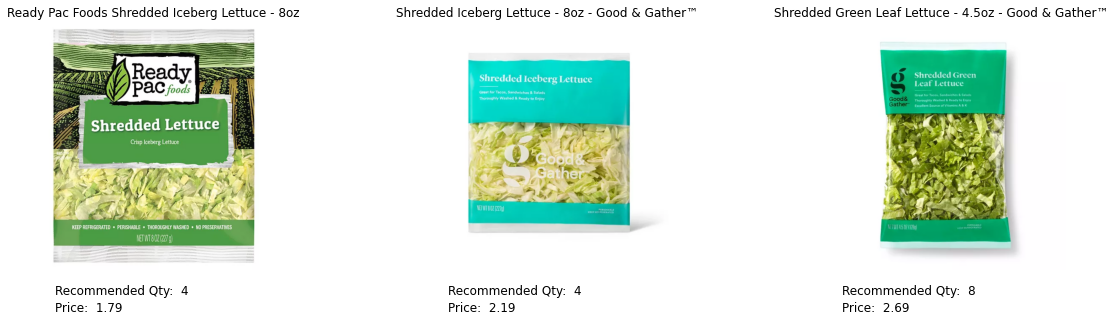

chopped fresh parsley
[79495115 79495115 79495115]


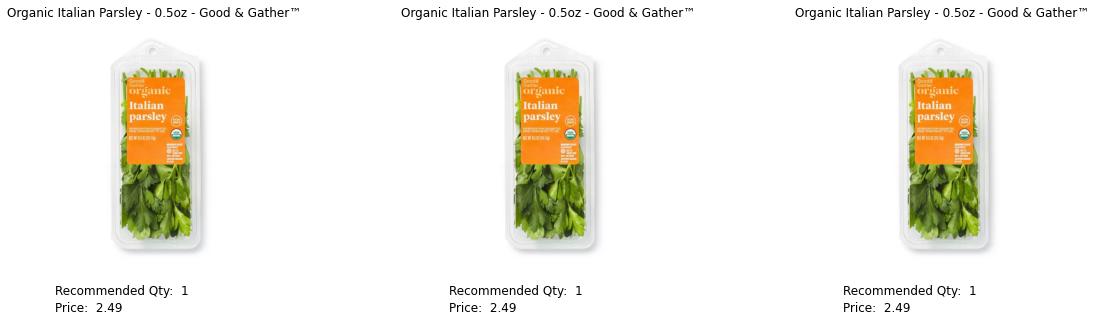

chopped fresh thyme
[13460605 77587948 79622362]


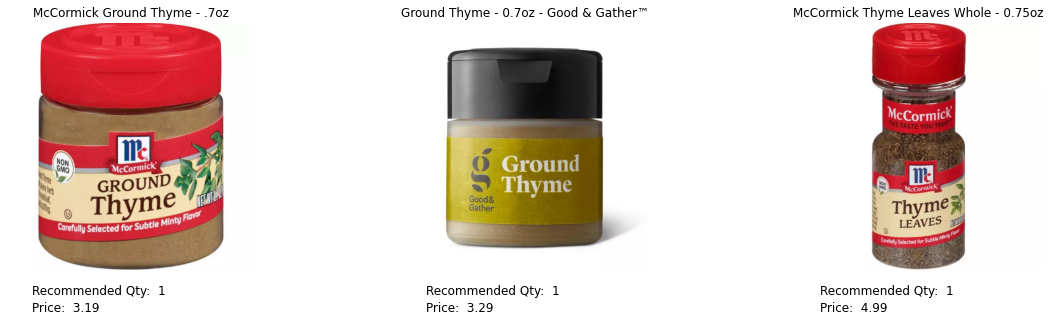

dijon mustard
[12946078 12958478 12946184]


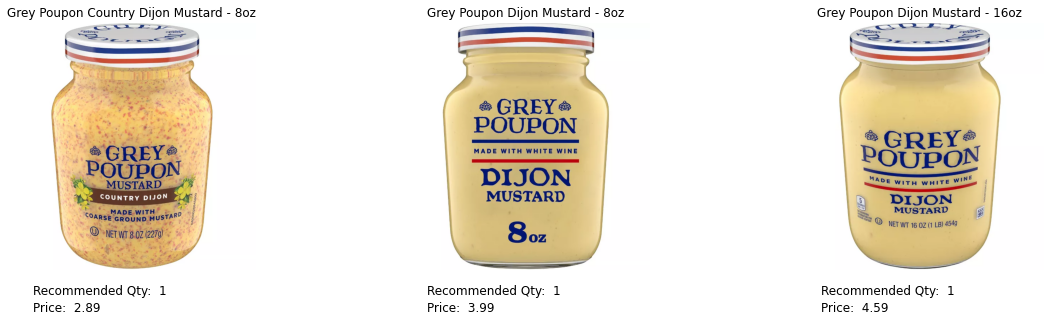

fresh thyme
[79495112 13460605 77587948]


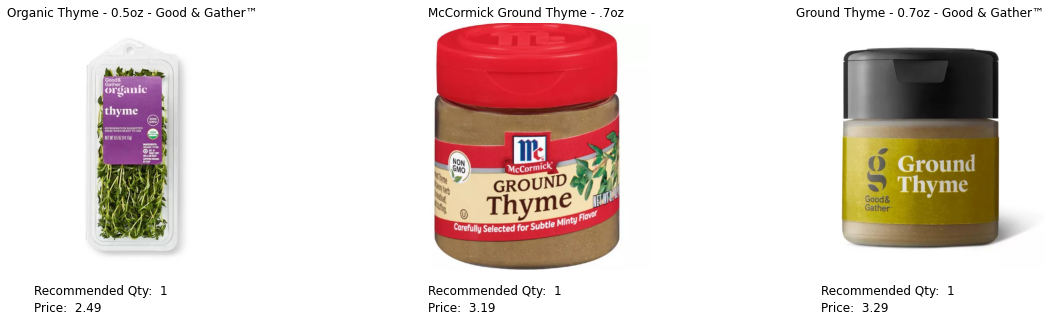

horseradish
[50474964 51068371 12935757]


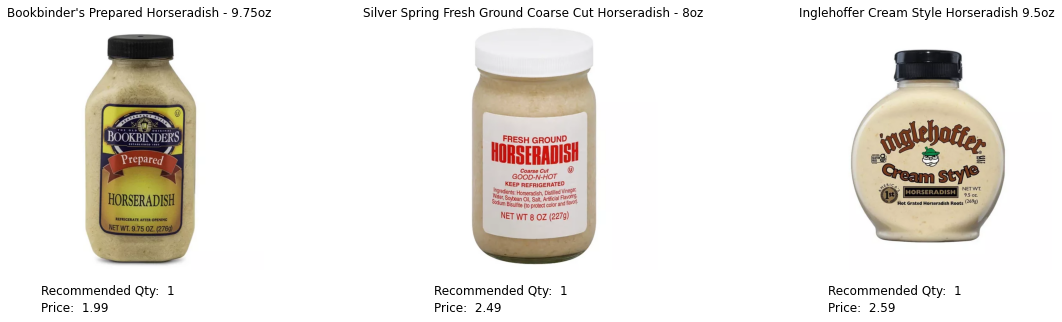

horseradish sauce
[16776299 12946175 12935374]


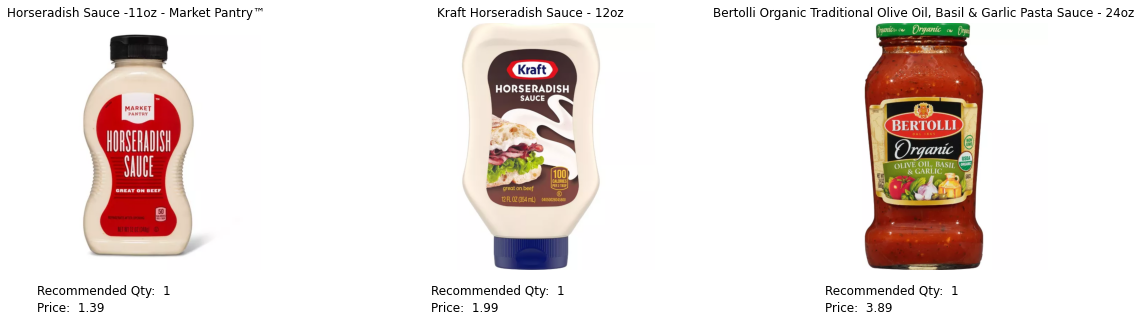

ketchup
[13652417 54518180 17295441]


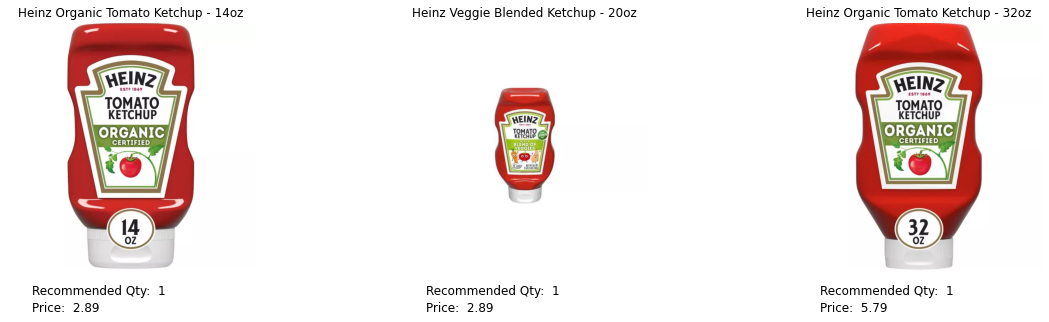

mayonnaise
[47087964 47110736 54509637]


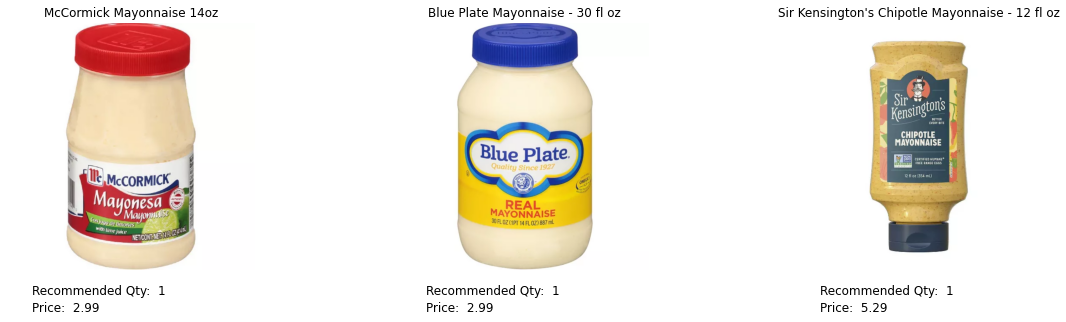

oz pastrami
[51107859 77594474 51462241]


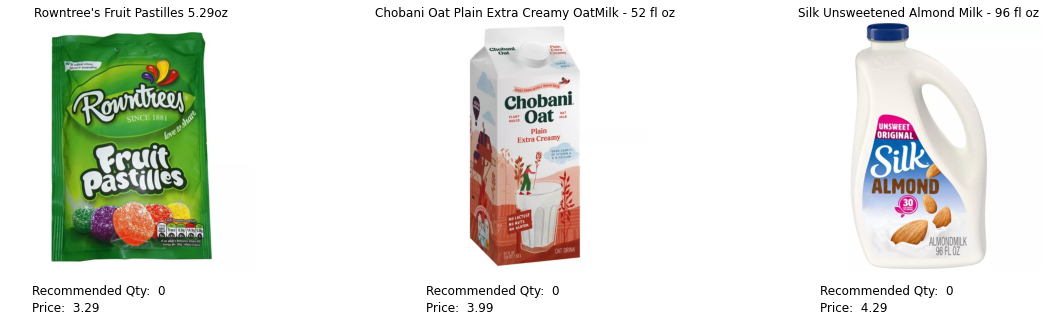

pepper
[14919034 14919665 14919579]


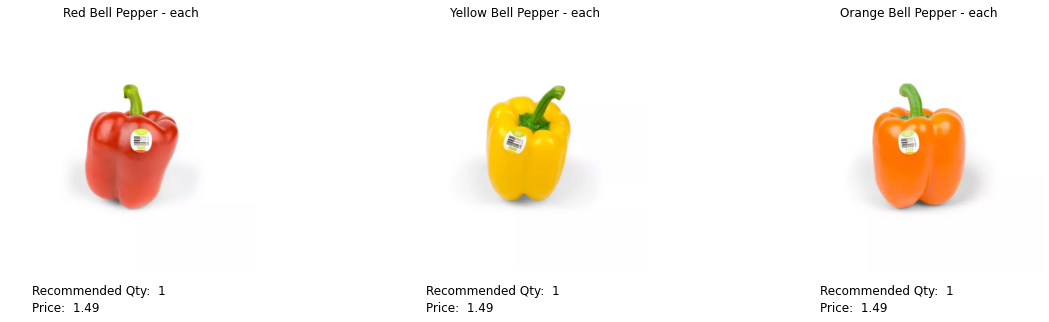

salt
[78140861 13171236 47094599]


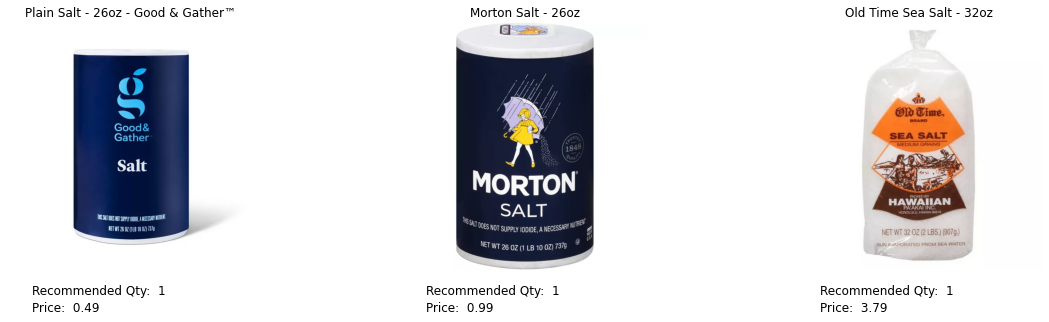

salt and pepper
[77588365 13170721 78096196]


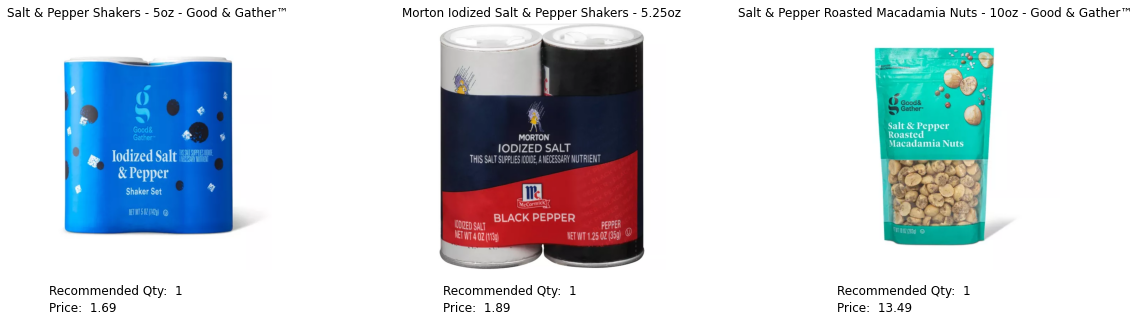

slice bavaria blue cheese
[54564644 47562137 54564613]


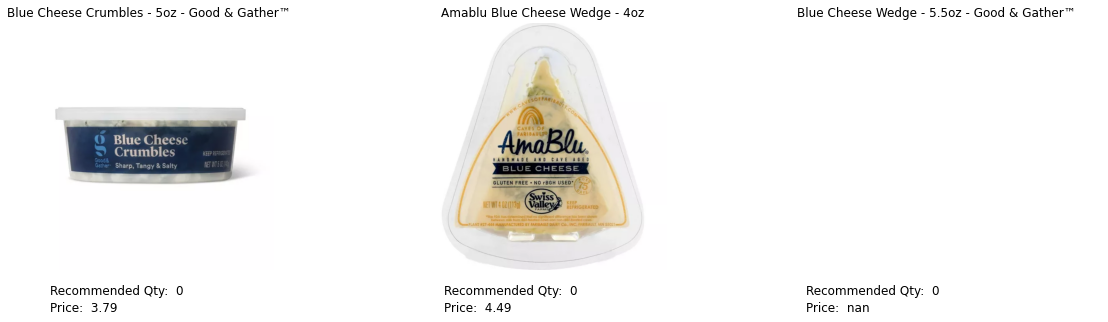

slice jewish rye bread
[16653089 14716257 12935754]


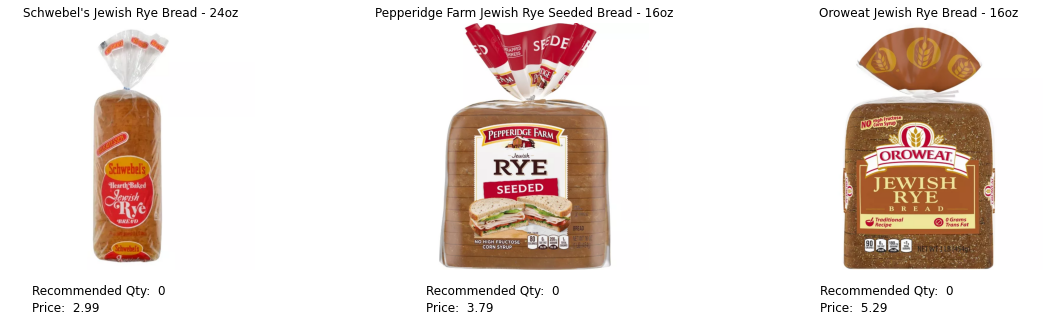

slice swiss cheese
[14930800 47104925 13305394]


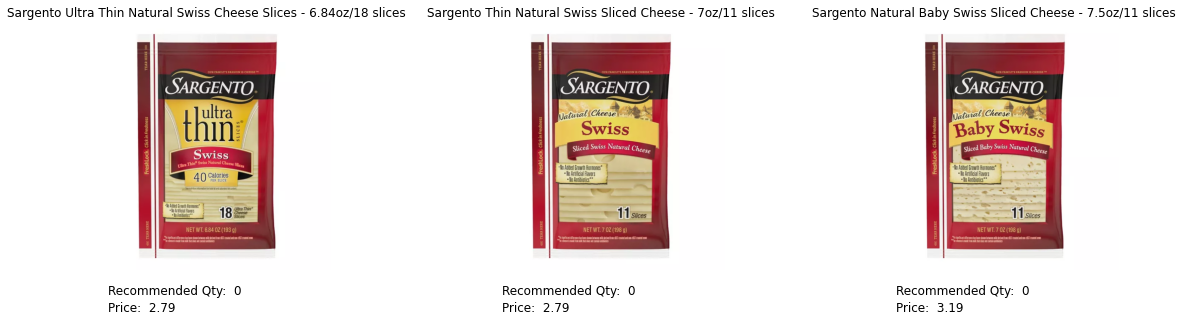

sour cream
[47104403 21510127 23986057]


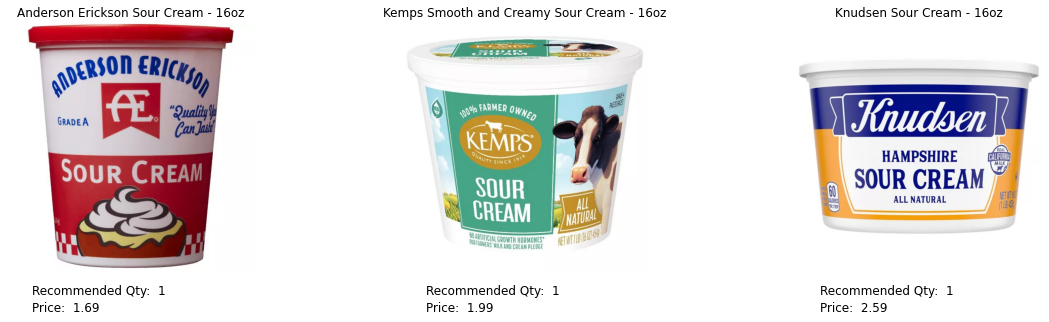

vinegar
[54633873 47846730 47851264]


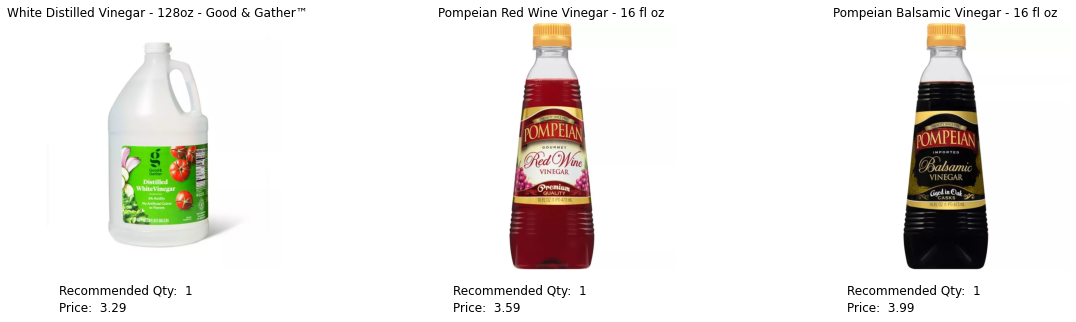

In [14]:
dp.display_products_df(display_df, 3)

In [ ]:
#4567
#7609
#32659
#4623